In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List, Tuple
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda

from torchvision.transforms import Compose
from torchvision import transforms
from torchvision.datasets import ImageFolder

import numpy as np

In [3]:
from models import SlimWide, torchvision_default_initialize_weights
from data_prep import stratified_split, DataSubSet

In [4]:
def plot_pred(img, label):
    plt.imshow(img)
    plt.title(label)

def sorted_sums(ds, m):
    sums = defaultdict(list)
    for i in range(len(ds)):
        x, label = ds[i]
        y = m(x.unsqueeze(0))
        y = F.softmax(y, dim=2)
        s = y.sum().item()
        sums[label].append(s)
    return {k: sorted(v) for k,v in sums.items()}

In [5]:
tf_eval = Compose([transforms.Grayscale(),
                   transforms.ToTensor(),
                   transforms.Normalize((0.4862745,), (0.1388,)),
                  ])

tf_train = Compose([transforms.Grayscale(),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4862745,), (0.1388,)),
                   ])

ds = ImageFolder('../photomask_trainingdata')
eval_idx, train_idx = stratified_split([x[1] for x in ds.samples])

ds_eval = DataSubSet(ds, eval_idx, transform=tf_eval)
ds_train = DataSubSet(ds, train_idx, transform=tf_train)

In [6]:
m = SlimWide()
torchvision_default_initialize_weights(m)

Text(0.5, 1.0, 'EVAL')

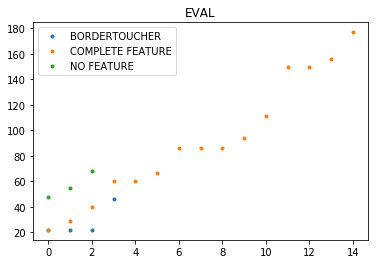

In [7]:
r = sorted_sums(ds_eval, m)
for k, v in r.items():
    label = label={v:k for k,v in ds.class_to_idx.items()}[k]
    plt.plot(v, ".", label=label)
plt.legend()
plt.title("EVAL")

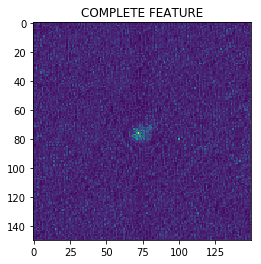

In [8]:
x, cls = ds_eval[10]
x = x.unsqueeze(0)
label = get_label(ds, cls)

y_mask = F.softmax(m(x), dim=2).data.cpu().squeeze(1)
#plot_pred(x.numpy().squeeze(), label+" INPUT")
plot_pred(y_mask[0].numpy(), label)

In [9]:
def loss_hinge(result_sum, min_sum:float = 2000, max_sum:float = 6000):
    loss = F.relu(result_sum - max_sum) + \
           F.relu(-result_sum + min_sum)
    return loss

losses = []
for s in torch.linspace(0, 100, 100):
    losses.append(loss_hinge(s, 40, 80))

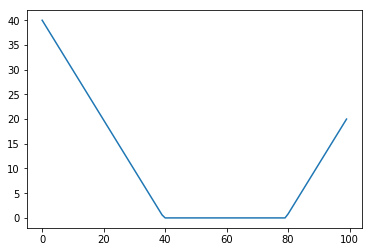

In [10]:
plt.plot(losses)

# TRAINING

In [11]:
TRUTH_BOUNDS = {"NO FEATURE": (0, 100//4),
                "COMPLETE FEATURE": (900//4, 2000//4), 
                "BORDERTOUCHER" : (500//4, 1800//4)
               }

In [12]:
from torch import optim
from torch.utils.data import DataLoader

In [13]:
def run_epoch(ds, m, optimizer, epoch_nr=0, num_workers=0, batch_size=4, 
              debug_print=True,
              debug_plot=True,
              train=True):
    if train:
        m.train()
    else:
        m.eval()
        
    dl = DataLoader(ds)
    device = next(m.parameters()).device
    
    losses = []
    sums = defaultdict(list) #How many pixels are active for each class
    
    for b, (imgs, classes) in enumerate(dl):
        if train:
            optimizer.zero_grad()
        
        imgs = imgs.to(device)
        preds = m(imgs)
        preds = F.softmax(preds, dim=2)

        single_losses = []
        for pred, _cls in zip(preds, classes):
            s = pred.sum()
            
            label = get_label(ds, _cls.item())
            lower, upper = TRUTH_BOUNDS[label]
            l = loss_hinge(s, lower, upper) / ((lower+upper)*0.5)
            single_losses.append(l)
            
            sums[label].append(s.item())

        loss = sum(single_losses)
        if train:
            loss.backward()
            optimizer.step()            
        
        if debug_print:
            labels = [get_label(ds, k.item()) for k in classes]
            print(f"E[{epoch_nr}]-train {b}: {loss:.2f}, shapes: {[i.shape for i in imgs]}, labels: {labels}")
        
        losses.append(loss.item())

    if debug_plot:
        for label, v in sums.items():
            plt.plot(sorted(v), ".", label=label)
        plt.legend()
        plt.title("TRAIN" if train else "EVAL")
        
    return losses

In [14]:
###########################
m = SlimWide()
torchvision_default_initialize_weights(m)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

m.to(device)

optimizer = optim.SGD(m.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-4)
epoch_nr = 0

E[1]-train 0: 0.34, shapes: [torch.Size([1, 61, 61])], labels: ['BORDERTOUCHER']
E[1]-train 1: 0.34, shapes: [torch.Size([1, 61, 61])], labels: ['BORDERTOUCHER']
E[1]-train 2: 0.27, shapes: [torch.Size([1, 98, 98])], labels: ['BORDERTOUCHER']
E[1]-train 3: 0.27, shapes: [torch.Size([1, 98, 98])], labels: ['BORDERTOUCHER']
E[1]-train 4: 0.27, shapes: [torch.Size([1, 98, 98])], labels: ['BORDERTOUCHER']
E[1]-train 5: 0.28, shapes: [torch.Size([1, 96, 96])], labels: ['BORDERTOUCHER']
E[1]-train 6: 0.14, shapes: [torch.Size([1, 175, 175])], labels: ['BORDERTOUCHER']
E[1]-train 7: 0.23, shapes: [torch.Size([1, 123, 123])], labels: ['BORDERTOUCHER']
E[1]-train 8: 0.23, shapes: [torch.Size([1, 123, 123])], labels: ['BORDERTOUCHER']
E[1]-train 9: 0.30, shapes: [torch.Size([1, 83, 83])], labels: ['BORDERTOUCHER']
E[1]-train 10: 0.32, shapes: [torch.Size([1, 73, 73])], labels: ['BORDERTOUCHER']
E[1]-train 11: 0.32, shapes: [torch.Size([1, 73, 73])], labels: ['BORDERTOUCHER']
E[1]-train 12: 0.32,

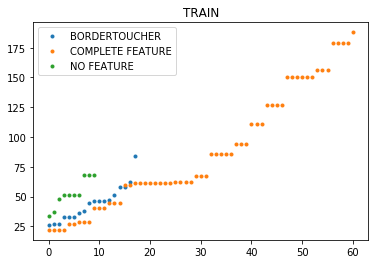

In [17]:
if True:
    losses = run_epoch(ds_train, m, optimizer, epoch_nr=epoch_nr, train=True)
    print(f"E[{epoch_nr}] AVERAGE:", sum(losses)/len(losses))
    epoch_nr += 1

E[1] AVERAGE: 0.6613438468087803


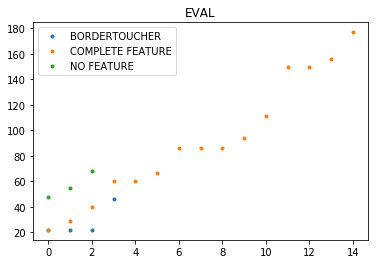

In [16]:
eval_losses = run_epoch(ds_eval, m, optimizer, epoch_nr=epoch_nr, train=False, debug_print=False)
print(f"E[{epoch_nr}] AVERAGE:", sum(eval_losses)/len(eval_losses))